In [2]:
import argparse
import cv2
import time
from tqdm import tqdm
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [3]:
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(os.path.join(path, folder)):
            images.append(os.path.join(path, os.path.join(folder, file)))

    if(train is True):
        np.random.shuffle(images)
    
    return images

In [4]:
def getDescriptors(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

In [5]:
def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

In [6]:
def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors

In [7]:
def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

In [8]:
def extractFeatures(kmeans, descriptor_list, image_count, no_clusters):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in tqdm(range(image_count)):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]
            feature = feature.reshape(1, 128)
            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

In [9]:
def normalizeFeatures(scale, features):
    return scale.transform(features)

In [10]:
def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

In [11]:
def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [12]:
def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    class_weight = {
        0: (807 / (7 * 140)),
        1: (807 / (7 * 140)),
        2: (807 / (7 * 133)),
        3: (807 / (7 * 70)),
        4: (807 / (7 * 42)),
        5: (807 / (7 * 140)),
        6: (807 / (7 * 142)) 
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

In [13]:
def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [14]:
def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["city", "face", "green", "house_building", "house_indoor", "office", "sea"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

In [15]:
def findAccuracy(true, predictions):
    accuracy = accuracy_score(true, predictions)
    print ('accuracy score: %0.3f' % accuracy)
    return accuracy

In [16]:
def trainModel(path, no_clusters, kernel):
    images = getFiles(True, path)
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    # label_count = 7
    image_count = len(images)

    for img_path in images:
        if("city" in img_path):
            class_index = 0
        elif("face" in img_path):
            class_index = 1
        elif("green" in img_path):
            class_index = 2
        elif("house_building" in img_path):
            class_index = 3
        elif("house_indoor" in img_path):
            class_index = 4
        elif("office" in img_path):
          class_index = 5
        else:
          class_index = 6

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)

    kmeans = clusterDescriptors(descriptors, no_clusters)

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)

    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)

    # plotHistogram(im_features, no_clusters)
    # print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)

    return kmeans, scale, svm, im_features

In [17]:
def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel):
    test_images = getFiles(False, path)

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "city",
        "1": "face",
        "2": "green",
        "3": "house_building",
        "4": "house_indoor",
        "5": "office",
        "6": "sea"
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        # print(des)
        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("city" in img_path):
                true.append("city")
            elif("face" in img_path):
                true.append("face")
            elif("green" in img_path):
                true.append("green")
            elif("house_building" in img_path):
                true.append("house_building")
            elif("house_indoor" in img_path):
                true.append("house_indoor")
            elif("office" in img_path):
                true.append("office")
            else:
                true.append("sea")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print(no_clusters)
    acc = findAccuracy(true, predictions)
    return {"accuracy": acc, 
            "predictions": predictions
            }

In [18]:
def execute(train_path, test_path, no_clusters, kernel):
    kmeans, scale, svm, im_features = trainModel(train_path, no_clusters, kernel)
    dict1 = testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)
    return dict1['accuracy']

In [19]:
train_path = 'Bag-of-Visual-Words-master/dataset/train'
test_path = 'Bag-of-Visual-Words-master/dataset/test'
no_clusters = 300
kernal_type = 'linear' # or 'precomputed'

if(not(kernal_type == "linear" or kernal_type == "precomputed")):
    print("Kernel type must be either linear or precomputed")
    exit(0)

history = []
k = range(10, 500, 10)
for no_clusters in k: 
    history.append(execute(train_path, test_path, int(no_clusters), kernal_type))

[ WARN:0@21.293] global shadow_sift.hpp:15 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736
100%|██████████| 209/209 [00:03<00:00, 53.33it/s]


10
accuracy score: 0.474


100%|██████████| 209/209 [00:03<00:00, 52.65it/s]


20
accuracy score: 0.522


100%|██████████| 209/209 [00:03<00:00, 52.86it/s]


30
accuracy score: 0.512


100%|██████████| 209/209 [00:04<00:00, 50.98it/s]


40
accuracy score: 0.526


100%|██████████| 209/209 [00:03<00:00, 52.72it/s]


50
accuracy score: 0.579


100%|██████████| 209/209 [00:04<00:00, 52.12it/s]


60
accuracy score: 0.569


100%|██████████| 209/209 [00:04<00:00, 51.77it/s]


70
accuracy score: 0.560


100%|██████████| 209/209 [00:04<00:00, 51.57it/s]


80
accuracy score: 0.522


100%|██████████| 209/209 [00:04<00:00, 51.54it/s]


90
accuracy score: 0.612


100%|██████████| 209/209 [00:04<00:00, 52.11it/s]


100
accuracy score: 0.579


100%|██████████| 209/209 [00:04<00:00, 49.26it/s]


110
accuracy score: 0.612


100%|██████████| 209/209 [00:04<00:00, 44.14it/s]


120
accuracy score: 0.589


100%|██████████| 209/209 [00:04<00:00, 50.58it/s]


130
accuracy score: 0.632


100%|██████████| 209/209 [00:04<00:00, 50.14it/s]


140
accuracy score: 0.608


100%|██████████| 209/209 [00:04<00:00, 51.05it/s]


150
accuracy score: 0.627


100%|██████████| 209/209 [00:04<00:00, 50.78it/s]


160
accuracy score: 0.593


100%|██████████| 209/209 [00:04<00:00, 49.88it/s]


170
accuracy score: 0.589


100%|██████████| 209/209 [00:04<00:00, 47.15it/s]


180
accuracy score: 0.603


100%|██████████| 209/209 [00:04<00:00, 49.36it/s]


190
accuracy score: 0.608


100%|██████████| 209/209 [00:04<00:00, 49.23it/s]


200
accuracy score: 0.574


100%|██████████| 209/209 [00:04<00:00, 48.95it/s]


210
accuracy score: 0.612


100%|██████████| 209/209 [00:04<00:00, 49.79it/s]


220
accuracy score: 0.574


100%|██████████| 209/209 [00:04<00:00, 49.13it/s]


230
accuracy score: 0.608


100%|██████████| 209/209 [00:04<00:00, 48.47it/s]


240
accuracy score: 0.598


100%|██████████| 209/209 [00:04<00:00, 49.27it/s]


250
accuracy score: 0.656


100%|██████████| 209/209 [00:04<00:00, 48.76it/s]


260
accuracy score: 0.569


100%|██████████| 209/209 [00:04<00:00, 48.56it/s]


270
accuracy score: 0.617


100%|██████████| 209/209 [00:04<00:00, 47.71it/s]


280
accuracy score: 0.574


100%|██████████| 209/209 [00:04<00:00, 47.34it/s]


290
accuracy score: 0.574


100%|██████████| 209/209 [00:04<00:00, 48.16it/s]


300
accuracy score: 0.598


100%|██████████| 209/209 [00:04<00:00, 47.92it/s]


310
accuracy score: 0.598


100%|██████████| 209/209 [00:04<00:00, 47.57it/s]


320
accuracy score: 0.608


100%|██████████| 209/209 [00:04<00:00, 47.44it/s]


330
accuracy score: 0.627


100%|██████████| 209/209 [00:04<00:00, 46.05it/s]


340
accuracy score: 0.612


100%|██████████| 209/209 [00:04<00:00, 45.45it/s]


350
accuracy score: 0.574


100%|██████████| 209/209 [00:04<00:00, 46.77it/s]


360
accuracy score: 0.589


100%|██████████| 209/209 [00:04<00:00, 46.60it/s]


370
accuracy score: 0.632


100%|██████████| 209/209 [00:04<00:00, 46.55it/s]


380
accuracy score: 0.598


100%|██████████| 209/209 [00:04<00:00, 46.15it/s]


390
accuracy score: 0.641


100%|██████████| 209/209 [00:04<00:00, 43.13it/s]


400
accuracy score: 0.627


100%|██████████| 209/209 [00:04<00:00, 46.01it/s]


410
accuracy score: 0.636


100%|██████████| 209/209 [00:04<00:00, 45.85it/s]


420
accuracy score: 0.598


100%|██████████| 209/209 [00:04<00:00, 45.65it/s]


430
accuracy score: 0.617


100%|██████████| 209/209 [00:04<00:00, 45.50it/s]


440
accuracy score: 0.627


100%|██████████| 209/209 [00:04<00:00, 45.19it/s]


450
accuracy score: 0.627


100%|██████████| 209/209 [00:04<00:00, 44.96it/s]


460
accuracy score: 0.579


100%|██████████| 209/209 [00:04<00:00, 44.96it/s]


470
accuracy score: 0.589


100%|██████████| 209/209 [00:04<00:00, 45.43it/s]


480
accuracy score: 0.627


100%|██████████| 209/209 [00:04<00:00, 44.77it/s]

490
accuracy score: 0.603


In [20]:
history

[0.47368421052631576,
 0.5215311004784688,
 0.5119617224880383,
 0.5263157894736842,
 0.5789473684210527,
 0.569377990430622,
 0.5598086124401914,
 0.5215311004784688,
 0.6124401913875598,
 0.5789473684210527,
 0.6124401913875598,
 0.5885167464114832,
 0.631578947368421,
 0.6076555023923444,
 0.6267942583732058,
 0.5933014354066986,
 0.5885167464114832,
 0.6028708133971292,
 0.6076555023923444,
 0.5741626794258373,
 0.6124401913875598,
 0.5741626794258373,
 0.6076555023923444,
 0.5980861244019139,
 0.6555023923444976,
 0.569377990430622,
 0.6172248803827751,
 0.5741626794258373,
 0.5741626794258373,
 0.5980861244019139,
 0.5980861244019139,
 0.6076555023923444,
 0.6267942583732058,
 0.6124401913875598,
 0.5741626794258373,
 0.5885167464114832,
 0.631578947368421,
 0.5980861244019139,
 0.6411483253588517,
 0.6267942583732058,
 0.6363636363636364,
 0.5980861244019139,
 0.6172248803827751,
 0.6267942583732058,
 0.6267942583732058,
 0.5789473684210527,
 0.5885167464114832,
 0.6267942583732

Text(0, 0.5, 'Accuracy')

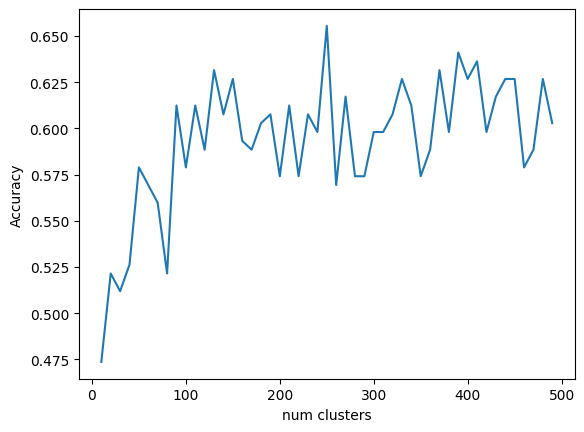

In [21]:
acc = [0.464, 0.498, 0.517, 0.560, 0.560, 0.555, 0.612, 0.579, 0.603]
plt.plot(k, history)
plt.xlabel('num clusters')
plt.ylabel('Accuracy')

In [55]:
import numpy as np 
import cv2 
import os
import re

# -------------------- Utility function ------------------------
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder 
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] folder : %s/%s/ ----> file : %s" % (progr, folder, sub_folder, filename), end="\r")
        

# -------------------- Load Dataset ------------------------
 
dataset_dir = "Bag-of-Visual-Words-master/dataset/" 

train_imgs, test_imgs = [], [] #list image matrix 
train_labels, test_labels = [],[]

descs = []
for folder in os.listdir(dataset_dir):
    if folder == 'train': 
        for sub_folder in os.listdir(os.path.join(dataset_dir, folder)):
            sub_folder_files = os.listdir(os.path.join(dataset_dir, folder, sub_folder))
            len_sub_folder = len(sub_folder_files) - 1
            for i, filename in enumerate(sub_folder_files):
                img = cv2.imread(os.path.join(dataset_dir, folder, sub_folder, filename))
                
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                h, w = gray.shape
                ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
                crop = gray[ymin:ymax, xmin:xmax]
                
                resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5)
                
                train_imgs.append(resize)
                train_labels.append(normalize_label(os.path.splitext(filename)[0]))
                descs.append(normalize_desc(folder, sub_folder))
                
                print_progress(i, len_sub_folder, folder, sub_folder, filename)

    else:
        for sub_folder in os.listdir(os.path.join(dataset_dir, folder)):
            sub_folder_files = os.listdir(os.path.join(dataset_dir, folder, sub_folder))
            len_sub_folder = len(sub_folder_files) - 1
            for i, filename in enumerate(sub_folder_files):
                img = cv2.imread(os.path.join(dataset_dir, folder, sub_folder, filename))
                
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
                h, w = gray.shape
                ymin, ymax, xmin, xmax = h//3, h*2//3, w//3, w*2//3
                crop = gray[ymin:ymax, xmin:xmax]
                
                resize = cv2.resize(crop, (0,0), fx=0.5, fy=0.5)
                
                test_imgs.append(resize)
                test_labels.append(normalize_label(os.path.splitext(filename)[0]))
                descs.append(normalize_desc(folder, sub_folder))
                
                print_progress(i, len_sub_folder, folder, sub_folder, filename)


[##########] folder : test/green/ ----> file : green_test-009.jpg
[##########] folder : test/city/ ----> file : city_test-022.jpg
[##########] folder : test/office/ ----> file : office_test-004.jpg
[##########] folder : test/face/ ----> file : face_test-011.jpg
[##########] folder : test/house_indoor/ ----> file : house_indoor_test-005.jpg
[##########] folder : test/house_building/ ----> file : house_building_test-025.jpg
[##########] folder : test/sea/ ----> file : sea_test-008.jpg
[##########] folder : train/green/ ----> file : green-103.jpgg
[##########] folder : train/city/ ----> file : city-022.jpg
[##########] folder : train/office/ ----> file : office-109.jpg
[##########] folder : train/face/ ----> file : face-108.jpg
[##########] folder : train/house_indoor/ ----> file : house_indoor-016.jpg
[##########] folder : train/house_building/ ----> file : house_building-066.jpg


In [56]:
from skimage.feature import graycomatrix, graycoprops

# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], lvl=256, sym=True, norm=True):
    
    glcm = graycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)
    feature = []
    glcm_props = [propery for name in props for propery in graycoprops(glcm, name)[0]]
    for item in glcm_props:
            feature.append(item)
    return feature

In [57]:
# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

glcm_train_agls = []
for img, label in zip(train_imgs, train_labels): 
    glcm_train_agls.append(
            calc_glcm_all_agls(img, 
                                label, 
                                props=properties)
                            )
 
train_columns = []
angles = ['0', '45', '90','135', '180']
for name in properties :
    for ang in angles:
        train_columns.append(name + "_" + ang)
        
# columns.append("label")

In [58]:

properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

glcm_test_agls = []
for img, label in zip(test_imgs, test_labels): 
    glcm_test_agls.append(
            calc_glcm_all_agls(img, 
                                label, 
                                props=properties)
                            )
 
test_columns = []
angles = ['0', '45', '90','135', '180']
for name in properties :
    for ang in angles:
        test_columns.append(name + "_" + ang)
    

In [59]:
import pandas as pd 

# Create the pandas DataFrame for GLCM features data
glcm_train_df = pd.DataFrame(glcm_train_agls, 
                      columns = train_columns)

glcm_train_df = glcm_train_df.to_numpy()
glcm_train_df.shape



glcm_test_df = pd.DataFrame(glcm_test_agls, 
                      columns = test_columns)

glcm_test_df = glcm_test_df.to_numpy()


print(glcm_train_df.shape)
print(glcm_test_df.shape)


(807, 30)
(209, 30)


In [60]:
def trainModel_glcm(path, no_clusters, kernel, glcm_data):
    images = getFiles(True, path)
    sift = cv2.xfeatures2d.SIFT_create()
    descriptor_list = []
    train_labels = np.array([])
    label_count = 7
    image_count = len(images)

    for img_path in images:
        if("city" in img_path):
            class_index = 0
        elif("face" in img_path):
            class_index = 1
        elif("green" in img_path):
            class_index = 2
        elif("house_building" in img_path):
            class_index = 3
        elif("house_indoor" in img_path):
            class_index = 4
        elif("office" in img_path):
          class_index = 5
        else:
          class_index = 6

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)

    kmeans = clusterDescriptors(descriptors, no_clusters)

    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters)

    final_features = np.concatenate([im_features, glcm_data], axis=1)

    norms = np.linalg.norm(final_features, axis=1, keepdims=True)
    
    norm_feat = final_features/norms

    svm = findSVM(final_features, train_labels, kernel)

    return kmeans, svm, norm_feat

In [61]:
def testModel_glcm(path, kmeans, svm, im_features, no_clusters, kernel, glcm_data):
    test_images = getFiles(False, path)

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "city",
        "1": "face",
        "2": "green",
        "3": "house_building",
        "4": "house_indoor",
        "5": "office",
        "6": "sea"
    }

    sift = cv2.xfeatures2d.SIFT_create()

    for img_path in test_images:
        
        img = readImage(img_path)
        des = getDescriptors(sift, img)
        # print(des)
        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("city" in img_path):
                true.append("city")
            elif("face" in img_path):
                true.append("face")
            elif("green" in img_path):
                true.append("green")
            elif("house_building" in img_path):
                true.append("house_building")
            elif("house_indoor" in img_path):
                true.append("house_indoor")
            elif("office" in img_path):
                true.append("office")
            else:
                true.append("sea")
    
    descriptors = vstackDescriptors(descriptor_list)
    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters)
    final_features = np.concatenate([test_features, glcm_data], axis=1)
    norms = np.linalg.norm(final_features, axis=1, keepdims=True)
    norm_feat = final_features/norms

    kernel_test = final_features

    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print(no_clusters)
    findAccuracy(true, predictions)

In [62]:
for no_clusters in range(10, 100, 10):
    kmeans, svm, im_features = trainModel_glcm('Bag-of-Visual-Words-master/dataset/train', no_clusters, 'linear', glcm_train_df)
    testModel_glcm('Bag-of-Visual-Words-master/dataset/test', kmeans, svm, im_features, no_clusters,"linear", glcm_test_df )

100%|██████████| 807/807 [00:14<00:00, 57.58it/s]


Text(0, 0.5, 'Accuracy')

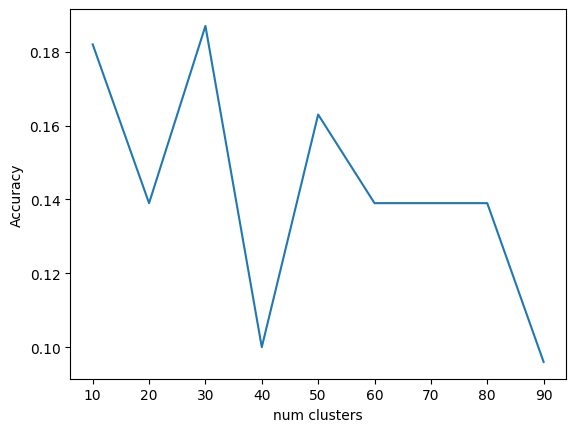

In [70]:
acc = [0.182, 0.139, 0.187, 0.100, 0.163, 0.139, 0.139, 0.139, 0.096]
k = range(10, 100, 10)
plt.plot(k, acc)
plt.xlabel('num clusters')
plt.ylabel('Accuracy')